In [248]:
import pandas as pd
import numpy as np

import gc
import os
import sys
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from numpy import sqrt
from tqdm import tqdm_notebook

from itertools import product

import lightgbm as lgb
from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

## Load Data

In [249]:
DATA_FOLDER ='../data/'

transactions     = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items            = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories  = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops            = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
# set index to ID to avoid droping it later
test             = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv')).set_index('ID')

## EDA

### Outliers

Check outliers especially value data `item_price` and `item_cnt_day`

In [250]:
transactions.item_price.min()

-1.0

In [251]:
transactions.item_price.max()

307980.0

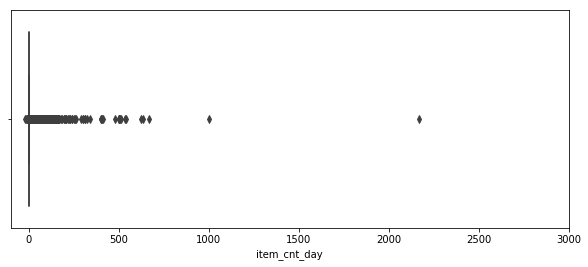

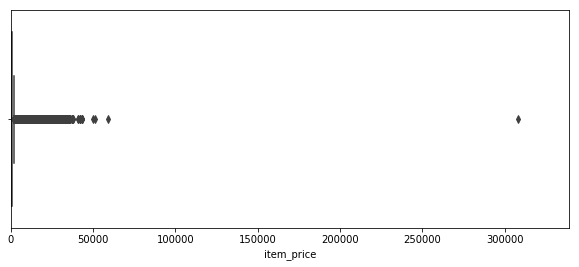

In [252]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=transactions.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(transactions.item_price.min(), transactions.item_price.max()*1.1)
sns.boxplot(x=transactions.item_price)

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1000

In [253]:
transactions = transactions[transactions['item_cnt_day'] < 1000]
transactions = transactions[transactions['item_price'] < 100000]

In [254]:
transactions.item_price.min()

-1.0

In [255]:
transactions[transactions['item_price']  < 0.0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


There is one item with price below zero. Fill it with this shop, item and date_block_num median.

In [256]:
transactions.loc[transactions['item_price']  < 0.0] = transactions[(transactions['shop_id'] == 32) & 
                                                                   (transactions['item_id'] == 2973) & 
                                                                   (transactions['date_block_num'] == 4)]['item_price'].median()

### Dulicate check

In [257]:
shops.duplicated('shop_name')

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
50    False
51    False
52    False
53    False
54    False
55    False
56    False
57    False
58    False
59    False
dtype: bool

### Shops, Items, Items Category processing

In [258]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [259]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [260]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


Using Google to transalte Russian to English. 

For example:

Shops:  ***Волжский ТЦ "Волга Молл"***	means ***Volzhsky shopping center "Volga Mall"***

item categories ***Аксессуары - PS2*** means ***Accessories - PS2*** 

So, we know:

- Each shop_name starts with the city name.
- Each category contains type and subtype in its name.

In [261]:
# Split city name, type and subtype
# Encode label value using LabelEncoder

shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
# if subtype is nan then type
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## Feature Engineering

### Monthly sales

Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. In the other hand train set contains only pairs which were sold or returned in the past. 

The main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data.

In [265]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(transactions.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [266]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = transactions[transactions.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)


12.70109224319458

### Revenue

Added reuenue value using `item_price * item_cnt_day`

In [268]:
transactions['revenue'] = transactions['item_price'] *  transactions['item_cnt_day']

### Aggregate data

In [270]:
group = transactions.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

/Users/saneryee/anaconda3/envs/aienv/lib/python3.6/site-packages/pandas/core/reshape/merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)
/Users/saneryee/anaconda3/envs/aienv/lib/python3.6/site-packages/pandas/core/reshape/merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


To use time tricks append test pairs to the matrix.

In [272]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [273]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month

Merge `shops`,`items`,`item_catrgories`

In [274]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, item_categories, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

Traget lags

In [276]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df


In [277]:
matrix = lag_feature(matrix, [1,2,3,4,5,6,12], 'item_cnt_month')

Mean encoded features

In [278]:
def mean_feature_eng(df,index_cols, col_name):
    
    group = df.groupby(index_cols).agg({'item_cnt_month': ['mean']})
    group.columns = [col_name]
    group.reset_index(inplace=True)

    df = pd.merge(df, group, on=index_cols, how='left')
    df[col_name] = df[col_name].astype(np.float16)
    df = lag_feature(df, [1], col_name)
    df.drop([col_name], axis=1, inplace=True)
    
    return df

In [279]:
# average by month
matrix = mean_feature_eng(matrix,['date_block_num'], 'date_avg_item_cnt')

# average by month and item_id
matrix = mean_feature_eng(matrix,['date_block_num', 'item_id'], 'date_item_avg_item_cnt')

# average by month and shop
matrix = mean_feature_eng(matrix,['date_block_num', 'shop_id'], 'date_shop_avg_item_cnt')

# average by month and item_category
matrix = mean_feature_eng(matrix,['date_block_num', 'item_category_id'], 'date_cat_avg_item_cnt')

# average by month, shop and itme_category_id
matrix = mean_feature_eng(matrix,['date_block_num', 'shop_id', 'item_category_id'], 'date_shop_cat_avg_item_cnt')

# average by month, shop and type_code
matrix = mean_feature_eng(matrix,['date_block_num', 'shop_id', 'type_code'], 'date_shop_type_avg_item_cnt')

# shop and subtype_code
matrix = mean_feature_eng(matrix,['date_block_num', 'shop_id', 'subtype_code'], 'date_shop_subtype_avg_item_cnt')

# ['date_block_num', 'city_code']
matrix = mean_feature_eng(matrix,['date_block_num', 'city_code'], 'date_city_avg_item_cnt')

# month item and city 
matrix = mean_feature_eng(matrix,['date_block_num', 'item_id', 'city_code'], 'date_item_city_avg_item_cnt')

# type_code
matrix = mean_feature_eng(matrix,['date_block_num', 'type_code'], 'date_type_avg_item_cnt')

# subtype_code
matrix = mean_feature_eng(matrix,['date_block_num', 'subtype_code'], 'date_subtype_avg_item_cnt')

### Trend features

* Price trend for the last six months.

In [280]:
group = transactions.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = transactions.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

/Users/saneryee/anaconda3/envs/aienv/lib/python3.6/site-packages/pandas/core/reshape/merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


* Last month shop revenue trend

In [281]:
group = transactions.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

/Users/saneryee/anaconda3/envs/aienv/lib/python3.6/site-packages/pandas/core/reshape/merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)
/Users/saneryee/anaconda3/envs/aienv/lib/python3.6/site-packages/pandas/core/reshape/merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)
/Users/saneryee/anaconda3/envs/aienv/lib/python3.6/site-packages/pandas/core/reshape/merge.py:970: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


### Special features

Number of days in a month. There are no leap years.

In [282]:
matrix['month'] = matrix['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.

In [283]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         

In [284]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num  

Months since the first sale for each shop/item pair and for item only.

In [285]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

### Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [286]:
matrix = matrix[matrix.date_block_num > 11]

Producing lags brings a lot of nulls.

In [287]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [288]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4',
       'item_cnt_month_lag_5', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1', 'month', 'days', 'item_shop_last_sale',
       'item_last_sale', 'item_shop_first_sale', 'item_first_sale'],
      dtype='object')

In [289]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 34 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
city_code                               int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_4                    float16
item_cnt_month_lag_5                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_12                   float16
date_avg_item_cnt_lag_1                 float16
date_item_avg_item_cnt_lag_1            float16
date_shop_avg_item_cnt_lag_1            float16
date_cat_avg_item_cnt_lag_1         

In [290]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del item_categories
del transactions
# leave test for submission
gc.collect();

## Model

In [ ]:
# load data pkl
data = pd.read_pickle('data.pkl')

Select perfect features

In [362]:
data = data[[
    'date_block_num', 
    'shop_id', 
    'item_id', 
    'item_cnt_month', 
    'city_code',
    'item_category_id', 
    'type_code', 
    'subtype_code', 
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2', 
    'item_cnt_month_lag_3', 
    'item_cnt_month_lag_4',
    'item_cnt_month_lag_5', 
    'item_cnt_month_lag_6', 
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1', 
    'date_item_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_1', 
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1', 
    'date_shop_type_avg_item_cnt_lag_1',
    'date_shop_subtype_avg_item_cnt_lag_1', 
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1', 
    'date_type_avg_item_cnt_lag_1',
    'date_subtype_avg_item_cnt_lag_1', 
    'delta_price_lag',
    'delta_revenue_lag_1', 
    'month', 
    'days', 
    'item_shop_last_sale',
    'item_last_sale', 
    'item_shop_first_sale', 
    'item_first_sale']]

In [363]:
# Check  NaN and infinity
np.any(np.isnan(data))

True

In [364]:
data = data.fillna(0)

In [365]:
np.any(np.isnan(data))

False

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [367]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = data[data.date_block_num < 33]['item_cnt_month']

X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = data[data.date_block_num == 33]['item_cnt_month']

X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

### LinearRegression

In [325]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
y_pred_lr = lr.predict(X_valid.values)

rmse_lr = sqrt(mean_squared_error(y_valid, y_pred_lr))
print('Test RMSE for linear is %f' % rmse_lr)

y_test_lr = lr.predict(X_test.values)

/Users/saneryee/anaconda3/envs/aienv/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Test RMSE for linear is 0.965603


In [ ]:
# save predictions for an ensemble
pickle.dump(y_pred_lr, open('lr_train.pickle', 'wb'))
pickle.dump(y_test_lr, open('lr_test.pickle', 'wb'))

### XGBRegressor

In [ ]:
xgb = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

xgb.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

y_pred_xgb = xgb.predict(X_valid).clip(0, 20)
y_test_xgb = model.predict(X_test).clip(0, 20)

In [ ]:
# save predictions for an ensemble
pickle.dump(y_pred_xgb, open('xgb_train.pickle', 'wb'))
pickle.dump(y_test_xgb, open('xgb_test.pickle', 'wb'))

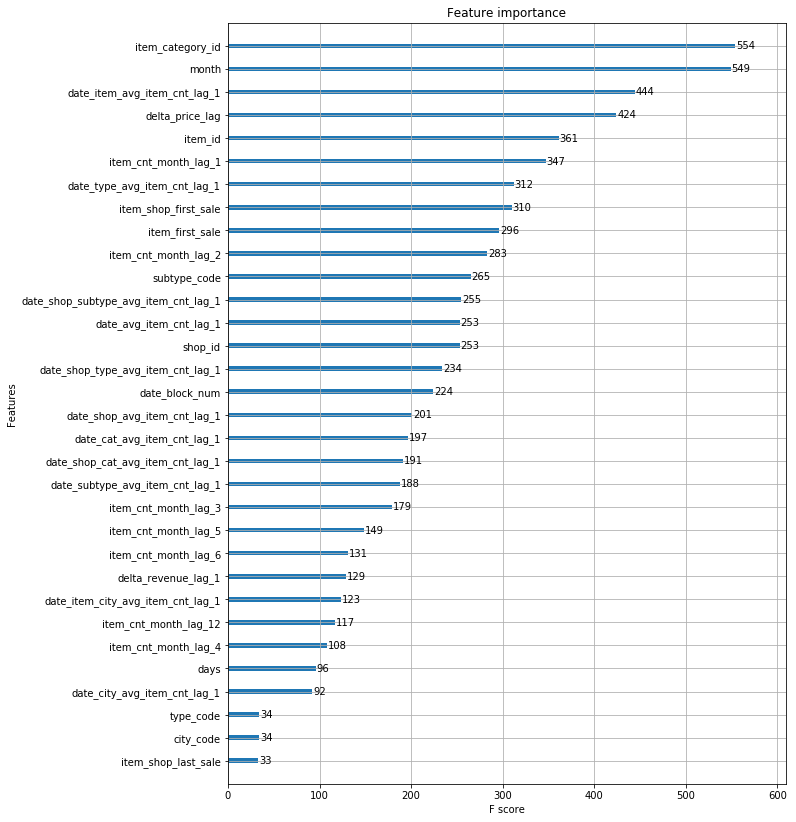

In [392]:
plot_features(xgb, (10,14))

In [ ]:
del data
gc.collect();

## Stacking

### Validation in presence of time component

**f) KFold scheme in time series**

In time-series task we usually have a fixed period of time we are asked to predict. Like day, week, month or arbitrary period with duration of T.

1. Split the train data into chunks of duration T. Select first M chunks.
2. Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until you hit the end. After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test.
3. Now we can use meta-features from first K chunks [M+1,M+2,..,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.

## Train meta-features

I implement scheme f), Here, we will use duration T equal to month and M=15.

That is, you need to get predictions (meta-features) from linear regression and XGB for months 27,28, 29, 30, 31, 32, 33 Use the same parameters as in above models.

In [385]:
X_train_stack = data[data.date_block_num < 34].drop(['item_cnt_month'], axis=1)
y_train_stack = data[data.date_block_num < 34]['item_cnt_month']

X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [386]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)


Test `date_block_num` is 34


In [387]:
dates_train = dates[dates < last_block] # 12-33
dates_test  = dates[dates == last_block]   #  34

# dates_train in 27，28，29，30，31，32, 33 
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])] 

In [388]:
# That is how we get target for the 2nd level dataset
y_train_level2 = y_train_stack[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])


In [ ]:
# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32, 33]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    #  Scheme f, set M = 15 form date_block_num = 12 to 33 
    # 12 + 15 = 27, begin: 27, train data 12 -26, test data 27, and so on 
    _X_train = data.loc[dates <  cur_block_num].drop(['item_cnt_month'], axis=1)
    _X_test  = data.loc[dates == cur_block_num].drop(['item_cnt_month'], axis=1)
    
    _y_train = data.loc[dates <  cur_block_num, 'item_cnt_month'].values
    _y_test  = data.loc[dates == cur_block_num, 'item_cnt_month'].values   
    
    
    # Model 1: linear regression
    lr.fit(_X_train.values, _y_train) 
    
    X_train_level2[dates_train_level2 == cur_block_num, 0] = lr.predict(_X_test.values) 
    
    # Model 2: XGBoost
    xgb.fit(
        X_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(_X_train, _y_train), (_X_test, _y_test)], 
        verbose=True, 
        early_stopping_rounds = 5)
    
    X_train_level2[dates_train_level2 == cur_block_num, 1] =  xgb.predict(_X_test)

Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [ ]:
lr.fit(X_train_level2, y_train_level2)

In [ ]:
train_preds = lr.predict(X_train_level2) 
test_preds = lr.predict(np.vstack((y_test_lr, y_test_xgb)).T)

## Finally, Submission

In [302]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test_xgb
})
submission.to_csv('submission.csv', index=False)